# Problem Set 3

### Import Packages

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import numpy as np
import pandas as pd
import pprint as pp
from skimage import data
import seaborn as sns

import sklearn
from sklearn.decomposition import PCA, TruncatedSVD, NMF

import timeit

## Question 1

### 1) Load the CIFAR-10 dataset from (https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz). (Don’t upload the dataset to github.)

To avoid uploading the data to GitHub, the directory with all subsequent data files has been added to the .gitignore for my repo. 

The CIFAR-10 dataset, according to the README for this dataset (https://www.cs.toronto.edu/~kriz/cifar.html), consists of 60,000 32x32 colour images in 10 classes, with 6000 images per class. There are 50,000 training images and 10,000 test images *which is approximately the 80-20 split requested for this assignment.* 

The dataset is divided into five training batches and one test batch, each with 10,000 images. The test batch contains exactly 1,000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class. 

The png files can be found here: https://www.kaggle.com/swaroopkml/cifar10-pngs-in-folders. 

In [2]:
# function to open pickled python files
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

### Meta Data

There are 10,000 cases per batch and 3072 values per visual.  
There are 10 classes: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, and truck

In [3]:
batches_meta = unpickle("data/cifar_10_batches_py/batches.meta")
print(batches_meta.keys())
print(batches_meta)

dict_keys([b'num_cases_per_batch', b'label_names', b'num_vis'])
{b'num_cases_per_batch': 10000, b'label_names': [b'airplane', b'automobile', b'bird', b'cat', b'deer', b'dog', b'frog', b'horse', b'ship', b'truck'], b'num_vis': 3072}


### Explore Batch 1

There are four keys in each batch: 
- the batch label
- the labels corresponding to the image
- the 3072 array to define each image
- the filename.

In [4]:
batch_1 = unpickle("data/cifar_10_batches_py/data_batch_1")
print(len(batch_1))
print(batch_1.keys())

4
dict_keys([b'batch_label', b'labels', b'data', b'filenames'])


In [5]:
pp.pprint(batch_1[b'batch_label'])

b'training batch 1 of 5'


In [6]:
pp.pprint(batch_1[b'labels'][:20]) # first 20 image labels

[6, 9, 9, 4, 1, 1, 2, 7, 8, 3, 4, 7, 7, 2, 9, 9, 9, 3, 2, 6]


In [7]:
pp.pprint(batch_1[b'data'][0]) # first image array
print("Dimension:", batch_1[b'data'][0].ndim)
print("Shape:", batch_1[b'data'][0].shape)
print("Filename:", batch_1[b'filenames'][0])

array([ 59,  43,  50, ..., 140,  84,  72], dtype=uint8)
Dimension: 1
Shape: (3072,)
Filename: b'leptodactylus_pentadactylus_s_000004.png'


Let's view the training set's first image...

In [8]:
image1 = list(batch_1.values())[2][0] # extract first set of 3072 values

# divide array into 2D arrays for each color
# divide by 255 because max value for RGB scale
reds = np.reshape(image1[:1024],(32,32))/255
greens = np.reshape(image1[1024:2048],(32,32))/255
blues = np.reshape(image1[2048:],(32,32))/255

# create a 3D array
image1 = np.dstack((reds,greens,blues))
print("Dimension:", image1.ndim)
print("Shape:", image1.shape)

Dimension: 3
Shape: (32, 32, 3)


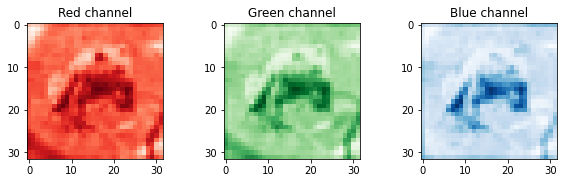

In [9]:
plt.figure(figsize=(10,2.5))
plt.subplot(131)
plt.gca().set_title('Red channel')
plt.imshow(reds, cmap='Reds', interpolation='nearest')
plt.subplot(132)
plt.gca().set_title('Green channel')
plt.imshow(greens, cmap='Greens', interpolation='nearest')
plt.subplot(133)
plt.gca().set_title('Blue channel')
plt.imshow(blues, cmap='Blues', interpolation='nearest')

plt.show()

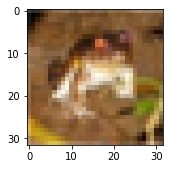

In [10]:
plt.figure(figsize=(2.5,2.5))
plt.imshow(image1, cmap=plt.cm.gray) 
plt.show()

Yay! After converting the arrayThis is an image of a frog.

**The above work helped me understand how the dataset was originally stored. At this point in my analysis, I noticed that the CIFAR-10 dataset could be accessed through Keras.** 

In [11]:
# conda install python=3.7 -y
# conda install tensorflow keras

import tensorflow
import keras
from keras.datasets import cifar10

Using TensorFlow backend.


### 2)	Make an 80%-20% split on the dataset into test and train data.

In [12]:
# x_train, x_test, y_train, y_test = train_test_split(x , y , test_size = 0.20, random_state = 1021)
(x_train, y_train), (x_test, y_test) = cifar10.load_data() # note: pre-split in Keras dataset

In [13]:
# The training and testing data is approximately in a 80-20 split.
print('Traning data shape:', x_train.shape)
print('Testing data shape:', x_test.shape)

Traning data shape: (50000, 32, 32, 3)
Testing data shape: (10000, 32, 32, 3)


In [14]:
# corresponding training and testing labels
print('Traning labels shape:', y_train.shape)
print('Testing labels shape:', y_test.shape)

Traning labels shape: (50000, 1)
Testing labels shape: (10000, 1)


In [15]:
# unique numbers from the train labels
classes = np.unique(y_train)
nClasses = len(classes)
print('Total number of classes : ', nClasses)
print('Output classes : ', classes)

# from meta data above we know which numbers correspond to which image class
label_dict = {
 0: 'airplane',
 1: 'automobile',
 2: 'bird',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'frog',
 7: 'horse',
 8: 'ship',
 9: 'truck',
}

Total number of classes :  10
Output classes :  [0 1 2 3 4 5 6 7 8 9]


View example images from training and testing set.

Text(0.5, 1.0, 'cat')

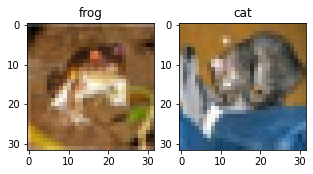

In [16]:
plt.figure(figsize=[5,5])

# Display the first image in training data (SAME AS ABOVE)
plt.subplot(121)
curr_img = np.reshape(x_train[0], (32,32,3))
plt.imshow(curr_img)
plt.title(str(label_dict[y_train[0][0]]))

# Display the first image in testing data
plt.subplot(122)
curr_img = np.reshape(x_test[0],(32,32,3))
plt.imshow(curr_img)
plt.title(str(label_dict[y_test[0][0]]))

### 3)	Scale the data so that each feature has a minimum value of 0 and a maximum value of 1.

In [17]:
np.min(x_train),np.max(x_train) # current minimum and maximum

(0, 255)

In [18]:
x_train = x_train/255.0
print("New Minimum:" , np.min(x_train), "New Maximum:" , np.max(x_train))
print("Same Training Shape:" ,x_train.shape)

New Minimum: 0.0 New Maximum: 1.0
Same Training Shape: (50000, 32, 32, 3)


### 4)	Use the following dimensionality reduction techniques for feature extraction: (More in Question 3)
    a) Principal Component Analysis
    b) Singular Value Decomposition
    c) Non-negative Matrix Factorization
    
To begin, I will create a dataframe of pixel values for each image with their respective labels.

In [19]:
# reshape image dimensions from three to one
x_train_flat = x_train.reshape(-1,3072)

# name each column by pixel number
feat_cols = ['p'+str(i + 1) for i in range(x_train_flat.shape[1])]
df_cifar = pd.DataFrame(x_train_flat,columns=feat_cols)

# add image labels
df_cifar['label'] = y_train

# check dataframe shape
print('Size of the dataframe: {}'.format(df_cifar.shape))

Size of the dataframe: (50000, 3073)


In [20]:
df_cifar.head() # each row is image, each column contains pixel or label info

,p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,...,p3064,p3065,p3066,p3067,p3068,p3069,p3070,p3071,p3072,label
0,0.231373,0.243137,0.247059,0.168627,0.180392,0.176471,0.196078,0.188235,0.168627,0.266667,...,0.847059,0.721569,0.549020,0.592157,0.462745,0.329412,0.482353,0.360784,0.282353,6
1,0.603922,0.694118,0.733333,0.494118,0.537255,0.533333,0.411765,0.407843,0.372549,0.400000,...,0.560784,0.521569,0.545098,0.560784,0.525490,0.556863,0.560784,0.521569,0.564706,9
2,1.000000,1.000000,1.000000,0.992157,0.992157,0.992157,0.992157,0.992157,0.992157,0.992157,...,0.305882,0.333333,0.325490,0.309804,0.333333,0.325490,0.313725,0.337255,0.329412,9
3,0.109804,0.098039,0.039216,0.145098,0.133333,0.074510,0.149020,0.137255,0.078431,0.164706,...,0.211765,0.184314,0.109804,0.247059,0.219608,0.145098,0.282353,0.254902,0.180392,4
4,0.666667,0.705882,0.776471,0.658824,0.698039,0.768627,0.694118,0.725490,0.796078,0.717647,...,0.294118,0.309804,0.321569,0.278431,0.294118,0.305882,0.286275,0.301961,0.313725,1


#### a) Principal Component Analysis

Principal component analysis (PCA) is a technique for reducing the dimensionality of such datasets, increasing interpretability but at the same time minimizing information loss. It does so by creating new uncorrelated variables that successively maximize variance.

In [21]:
pca = PCA(0.9) # want PCA model to capture 90% of variance

pca.fit(x_train_flat)
pca.n_components_ # need 99 components to acheive 90% variance explained

99

Therefore, to achieve 90% variance explained, use 99 principal components compared to the original 3072 pixels.

In [22]:
ncomp = 99
pca_cifar = PCA(n_components=ncomp)
principalComponents_cifar = pca_cifar.fit_transform(df_cifar.iloc[:,:-1])

# convert PC into dataframe
feat_cols = ['PC'+str(i + 1) for i in range(principalComponents_cifar.shape[1])]
principal_cifar_Df = pd.DataFrame(data = principalComponents_cifar, columns = feat_cols)
principal_cifar_Df['y'] = y_train
principal_cifar_Df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC91,PC92,PC93,PC94,PC95,PC96,PC97,PC98,PC99,y
0,-6.401018,2.729039,1.501711,-2.953333,-4.452582,0.647150,0.568989,0.092877,3.451771,1.168442,...,-0.635990,-0.316804,0.159353,0.062067,-0.753221,-0.457052,-0.565055,-0.236868,-0.029033,6
1,0.829783,-0.949943,6.003753,1.504931,-1.368500,1.225687,0.606882,-0.523086,2.584150,2.565564,...,0.417584,0.064930,0.021862,-0.205169,0.126837,-0.328007,0.672055,-0.351412,0.965973,9
2,7.730200,-11.522102,-2.753621,2.333595,-1.584409,-2.272213,-0.610438,-1.361358,-0.730908,-1.125914,...,-0.302671,-0.420768,-0.243481,-0.093237,0.604800,0.851663,-0.299922,-0.383984,0.192885,9
3,-10.347817,0.010738,1.101019,-1.304540,-1.594870,0.867600,0.194107,0.232392,1.467262,-0.359152,...,0.097569,0.182849,0.186498,-0.297515,0.097417,0.271438,-0.261593,0.229664,-0.034630,4
4,-2.625651,-4.969240,1.034585,3.306459,1.261683,0.031241,5.655493,1.426761,3.918136,-1.955221,...,-0.526354,-0.639216,-0.130388,-0.048844,-0.260944,-0.100058,0.322938,0.100302,-0.713189,1


In [23]:
print(pca_cifar.explained_variance_ratio_)
print('Total Variance Explained',sum(pca_cifar.explained_variance_ratio_))

[0.2907663  0.11253144 0.06694414 0.03676459 0.03608843 0.0280923
 0.02712992 0.02167162 0.02064641 0.01438001 0.01310563 0.01065978
 0.01049981 0.01004269 0.00918482 0.008174   0.00739608 0.0071613
 0.00687472 0.00643243 0.00594396 0.00587355 0.00495567 0.00490792
 0.00480452 0.00465877 0.00451348 0.00443654 0.00400781 0.00393866
 0.00366217 0.0033314  0.00323965 0.00310246 0.00307587 0.0029125
 0.00261219 0.00259261 0.00254345 0.00248378 0.00242671 0.0022932
 0.00228175 0.00221518 0.0021026  0.00206732 0.00192457 0.00190379
 0.0018466  0.00181696 0.00178052 0.001736   0.00171165 0.00169759
 0.00162334 0.0015859  0.00156412 0.001543   0.00153092 0.00149923
 0.00145783 0.00142324 0.00141114 0.00137705 0.00134851 0.00132663
 0.00128838 0.00124305 0.0012138  0.00121193 0.00118524 0.00116818
 0.00113939 0.00112247 0.00111645 0.00110985 0.00110252 0.00104779
 0.00103664 0.00101685 0.00099794 0.0009879  0.0009776  0.00097057
 0.00094145 0.00092453 0.00091728 0.0008983  0.00088222 0.00087479

#### b) Singular Value Decomposition

In linear algebra, the singular value decomposition is a factorization of a real or complex matrix. It generalizes the eigendecomposition of a square normal matrix with an orthonormal eigenbasis to any m\times n matrix.

In [24]:
# need 95 components to acheive at least 90% variance explained
svd = TruncatedSVD(n_components=95)

svd.fit(df_cifar)
print('Total Variance Explained',svd.explained_variance_ratio_.sum())

Total Variance Explained 0.9005369931384138


In [25]:
svd.singular_values_

array([6167.06941781, 1107.59770335,  871.0128406 ,  713.04883955,
        591.05083395,  583.20074447,  516.59774552,  506.24737248,
        454.29567094,  444.03129406,  370.00662877,  353.25084972,
        318.57753716,  316.3195339 ,  308.92840098,  295.64634661,
        278.9300634 ,  265.92216556,  260.23784057,  255.71331599,
        247.45282514,  237.91151299,  236.55800359,  217.23864071,
        216.15737405,  213.19357277,  210.38411574,  207.28087904,
        205.51519929,  195.31756489,  193.62008792,  186.82961948,
        178.0857341 ,  175.61739408,  171.86196055,  171.10865382,
        166.51480417,  157.74673262,  157.1051015 ,  155.61331971,
        153.716581  ,  151.99486986,  147.7686431 ,  147.38634963,
        145.21761005,  141.48049775,  140.29539263,  135.35664026,
        134.57264053,  132.58751775,  131.51984384,  130.18535957,
        128.57153796,  127.65089816,  126.97311848,  124.31048051,
        122.87332326,  122.02082913,  121.19444086,  120.71229

In [26]:
# apply SVD transform to dataset
transformed_svd = svd.fit_transform(df_cifar)
transformed_svd

array([[ 2.30323919e+01,  5.88741159e+00, -3.90330135e+00, ...,
         2.47283552e-02,  2.92903450e-01,  3.18425778e-02],
       [ 2.93500236e+01,  6.05349803e-01, -7.12279843e+00, ...,
        -1.21183245e-01, -4.90846878e-01,  1.29535303e-01],
       [ 3.11165700e+01, -1.31390322e+01, -1.32990045e+00, ...,
        -1.87047509e-01, -7.39621936e-01,  5.12372354e-02],
       ...,
       [ 2.46566309e+01, -1.06115507e+01, -3.98548617e+00, ...,
        -2.36754735e-01, -2.37221181e-01, -8.32718647e-01],
       [ 3.68048897e+01, -5.21104469e+00, -2.51692873e+00, ...,
        -3.88731437e-01,  4.63813391e-01,  2.61295838e-02],
       [ 2.88154629e+01, -2.89099756e+00,  4.90080311e+00, ...,
         3.27124317e-01,  6.12962080e-01,  3.81861234e-01]])

In [27]:
# convert SVD into dataframe
feat_cols = ['SVD'+str(i + 1) for i in range(transformed_svd.shape[1])]
svd_cifar_Df = pd.DataFrame(data = transformed_svd, columns = feat_cols)
svd_cifar_Df['y'] = y_train
svd_cifar_Df.head()

,SVD1,SVD2,SVD3,SVD4,SVD5,SVD6,SVD7,SVD8,SVD9,SVD10,...,SVD87,SVD88,SVD89,SVD90,SVD91,SVD92,SVD93,SVD94,SVD95,y
0,23.032392,5.887412,-3.903301,-3.911330,-1.451420,3.486323,-1.221588,-0.175539,0.105104,3.035011,...,-0.206743,-0.188237,0.060352,-0.364093,0.548822,-0.186654,0.024728,0.292903,0.031843,6
1,29.350024,0.605350,-7.122798,-1.288804,2.566934,-1.080014,-2.207081,0.434003,-0.394384,1.695247,...,0.546460,0.796546,0.840068,-0.804317,0.021162,0.311275,-0.121183,-0.490847,0.129535,9
2,31.116570,-13.139032,-1.329900,-4.231005,3.011896,0.020637,1.983243,0.272471,-1.260196,-1.147925,...,0.191094,0.085814,-0.385107,-0.178384,0.310955,0.017392,-0.187048,-0.739622,0.051237,9
3,17.708055,4.179032,-3.776211,-1.424109,-0.998337,1.921672,-0.722230,0.040444,0.149045,1.682877,...,0.345011,0.506918,0.132221,0.157263,0.063852,0.170307,0.150701,-0.007102,-0.224994,4
4,22.539212,-3.223153,-1.936590,2.999152,2.407146,-0.420751,-0.974675,-5.427899,1.080715,5.028589,...,-0.264405,0.017716,-0.011102,0.646869,0.463407,-0.453257,-0.117581,-0.568192,0.243911,1


#### c) Non-negative Matrix Factorization

Non-negative matrix factorization, also non-negative matrix approximation is a group of algorithms in multivariate analysis and linear algebra where a matrix V is factorized into two matrices W and H, with the property that all three matrices have no negative elements. 

In [28]:
nmf = NMF(n_components=100) # arbitrarily choose 100 components
trans_nmf = nmf.fit_transform(df_cifar)
print("Shape:", trans_nmf.shape)

/Users/britneybrown/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:315: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  "'nndsvda' in 1.1 (renaming of 0.26)."), FutureWarning)
/Users/britneybrown/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


Shape: (50000, 100)


In [29]:
feat_cols = ['NMF'+str(i + 1) for i in range(trans_nmf.shape[1])]
nmf_cifar_Df = pd.DataFrame(data = trans_nmf, columns = feat_cols)
nmf_cifar_Df['y'] = y_train
nmf_cifar_Df.head()

,NMF1,NMF2,NMF3,NMF4,NMF5,NMF6,NMF7,NMF8,NMF9,NMF10,...,NMF92,NMF93,NMF94,NMF95,NMF96,NMF97,NMF98,NMF99,NMF100,y
0,0.000000,0.000000,0.115813,0.195694,0.156499,0.000000,0.021629,0.000000,0.000000,0.058198,...,0.009937,0.000000,0.029292,0.009406,0.047752,0.000000,0.075327,0.029804,0.005619,6
1,0.000000,0.000000,0.129538,0.297500,0.212527,0.052654,0.046256,0.118578,0.069674,0.049829,...,0.020310,0.047634,0.008918,0.010298,0.168269,0.028293,0.011730,0.079204,0.045399,9
2,0.066495,0.060576,0.000000,0.309154,0.027935,0.097664,0.067700,0.173504,0.050219,0.140041,...,0.004835,0.000000,0.091124,0.004583,0.174407,0.135702,0.157113,0.074510,0.012111,9
3,0.000000,0.000000,0.116044,0.126934,0.083107,0.000000,0.092125,0.072798,0.012916,0.000000,...,0.000000,0.000000,0.023444,0.022710,0.050638,0.025646,0.066153,0.047276,0.015710,4
4,0.000000,0.000000,0.073410,0.027726,0.000000,0.005012,0.000000,0.054928,0.077351,0.130385,...,0.026361,0.060305,0.008690,0.002183,0.040444,0.093653,0.028245,0.037196,0.019575,1


### 5)	Bonus: Provide some visualization on how these methods are different.

In [30]:
ncomp = 2

# PCA Example
pca_cifar_ex = PCA(n_components=ncomp)
principalComponents_cifar_ex = pca_cifar_ex.fit_transform(df_cifar.iloc[:,:-1])

principal_cifar_Df_ex = pd.DataFrame(data = principalComponents_cifar_ex
                    , columns = ['principal component 1', 'principal component 2'])
principal_cifar_Df_ex['y'] = y_train

# SVD Example
svd_ex = TruncatedSVD(n_components=ncomp)
svd_ex.fit(df_cifar)

svd_transform_ex = svd_ex.transform(df_cifar)
feat_cols = ['SVD'+str(i + 1) for i in range(svd_transform_ex.shape[1])]
svd_cifar_Df_ex = pd.DataFrame(data = svd_transform_ex, columns = feat_cols)
svd_cifar_Df_ex['y'] = y_train

# NMF Example
nmf_ex = NMF(n_components=ncomp)
trans_nmf_ex = nmf.fit_transform(df_cifar)

feat_cols = ['NMF'+str(i + 1) for i in range(trans_nmf_ex.shape[1])]
nmf_cifar_Df_ex = pd.DataFrame(data = trans_nmf_ex, columns = feat_cols)
nmf_cifar_Df_ex['y'] = y_train

/Users/britneybrown/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:315: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  "'nndsvda' in 1.1 (renaming of 0.26)."), FutureWarning)
/Users/britneybrown/opt/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


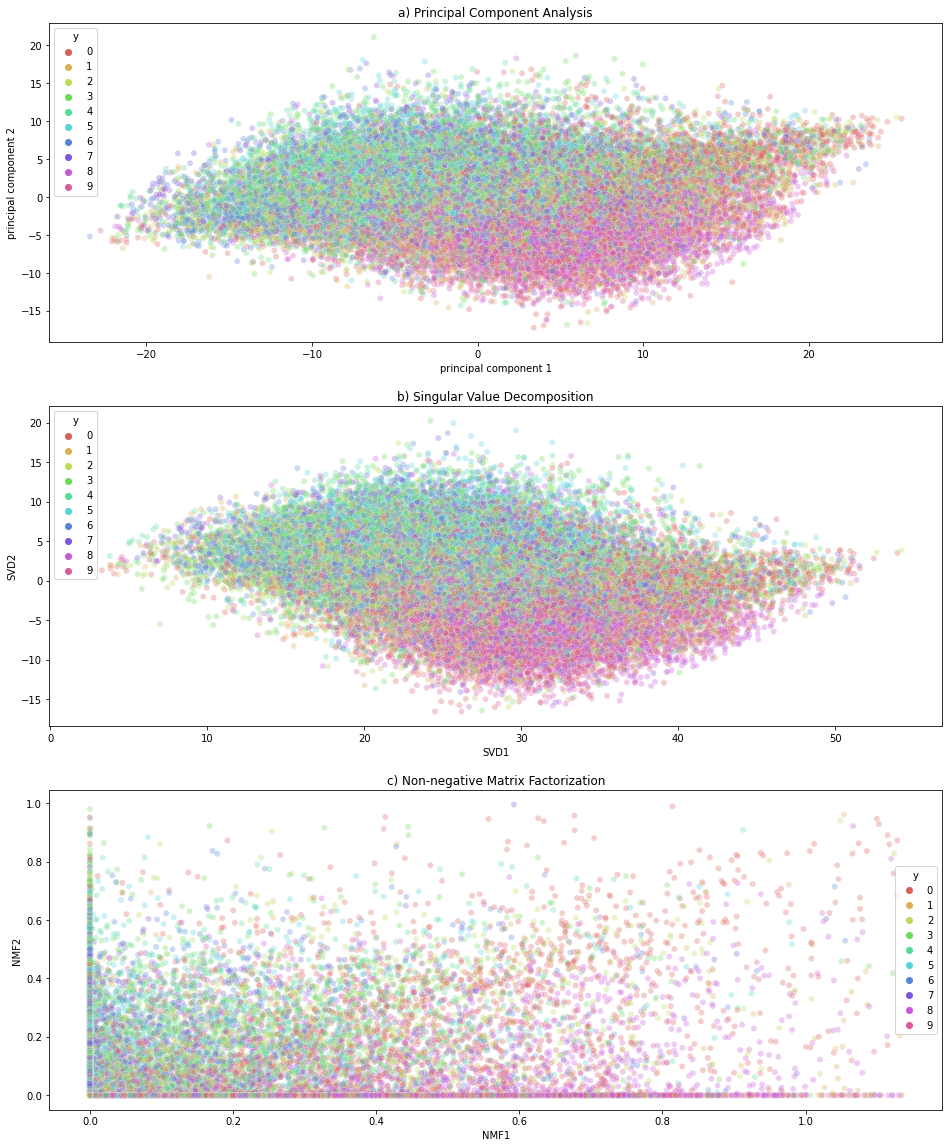

In [31]:
plt.figure(figsize=(16,20))

# PCA plot
plt.subplot(311)
plt.gca().set_title('a) Principal Component Analysis')
sns.scatterplot(
    x="principal component 1", y="principal component 2",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=principal_cifar_Df_ex,
    legend="full",
    alpha=0.3
)

# SVD plot
plt.subplot(312)
plt.gca().set_title('b) Singular Value Decomposition')
sns.scatterplot(
    x="SVD1", y="SVD2",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=svd_cifar_Df_ex,
    legend="full",
    alpha=0.3
)

# NMF plot
plt.subplot(313)
plt.gca().set_title('c) Non-negative Matrix Factorization')
sns.scatterplot(
    x="NMF1", y="NMF2",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=nmf_cifar_Df_ex,
    legend="full",
    alpha=0.3
)

plt.savefig('images/question1.png')

## Question 2

### 1) Fit the following classifiers on the dataset:
    a) Linear SVC
    b) Logistic Regresstion Classifier
    c) K-nearest Neighbors Classifier
    d) Perceptron

In [32]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, recall_score,precision_score

In [33]:
# prep testing data
x_test = x_test/255.0
x_test = x_test.reshape(-1,32,32,3)

# reshape image dimensions from three to one
x_test_flat = x_test.reshape(-1,3072)

In [34]:
# transform new data using already fitted pca
newdata_transformed = pca.transform(x_test_flat)

# name each column by pixel number
feat_cols = ['p'+str(i + 1) for i in range(newdata_transformed.shape[1])]
principal_cifar_test = pd.DataFrame(newdata_transformed,columns=feat_cols)

# add image labels
principal_cifar_test['label'] = y_test
principal_cifar_test.head()

,p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,...,p91,p92,p93,p94,p95,p96,p97,p98,p99,label
0,-3.479671,0.906426,1.251956,3.164191,-1.918240,1.659476,-0.068083,0.160349,-0.472169,-0.182596,...,-0.545092,-0.608618,0.108551,-0.183645,0.209230,0.027931,-0.473390,-0.073715,-0.174357,3
1,9.943158,-9.580553,5.068578,-2.961200,1.110012,-0.266616,-1.147632,-3.261594,1.486868,-3.944965,...,0.413626,0.065850,-0.101268,-0.307669,0.498750,-0.199660,0.099927,-0.676948,0.699004,8
2,4.704300,-8.837206,4.109285,1.030721,0.204448,-0.911759,5.313861,1.123139,1.150991,0.448419,...,-0.031693,-0.224322,-0.146823,-0.280326,-0.046095,-0.143887,0.043336,-0.119398,0.410197,8
3,8.046408,-3.812435,6.268061,-0.799734,-0.160306,4.558274,0.988285,0.892768,-1.147928,0.752415,...,-0.183590,-0.161597,-0.222708,0.778089,0.058857,0.282721,0.413735,-0.300682,-0.444346,0
4,-5.254615,4.320979,1.844344,-0.784487,0.386743,0.410722,0.666861,1.029134,0.203599,0.083327,...,0.187285,0.034242,0.170983,-0.663774,0.380714,-0.183378,-0.217617,0.329352,0.585919,6


In [35]:
X_train = principal_cifar_Df.iloc[:,:-1]
X_test = principal_cifar_test.iloc[:,:-1]

In [36]:
from IPython.core.display import display, HTML
display(HTML(f"""
   
        <ul class="list-group">
          <li class="list-group-item disabled" aria-disabled="true"><h4>Shape of Train and Test Dataset</h4></li>
          <li class="list-group-item"><h4>Number of rows in Train dataset is: <span class="label label-primary">{ X_train.shape[0]:,}</span></h4></li>
          <li class="list-group-item"> <h4>Number of columns Train dataset is <span class="label label-primary">{X_train.shape[1]}</span></h4></li>
          <li class="list-group-item"><h4>Number of rows in Test dataset is: <span class="label label-success">{ X_test.shape[0]:,}</span></h4></li>
          <li class="list-group-item"><h4>Number of columns Test dataset is <span class="label label-success">{X_test.shape[1]}</span></h4></li>
        </ul>
  
    """))

In [37]:
y_train = principal_cifar_Df.iloc[:,-1]
y_test = principal_cifar_test.iloc[:,-1]
print('Shape of the training labels: {}'.format(y_train.shape))
print('Shape of the testing labels: {}'.format(y_test.shape))

Shape of the training labels: (50000,)
Shape of the testing labels: (10000,)


#### a) Linear SVC

In [ ]:
Model = SVC()
Model.fit(X_train, y_train)

y_pred_svc = Model.predict(X_test) 
np.save("results/y_pred_svc.npy", y_pred_svc)

In [38]:
# load prediction array
y_pred_svc = np.load("results/y_pred_svc.npy")

# Accuracy score
print('Accuracy : ',accuracy_score(y_pred_svc,y_test))

# confusion matrix
print(confusion_matrix(y_test, y_pred_svc))

# Summary of the predictions made by the classifier
parta = classification_report(y_test, y_pred_svc)
print(parta)

Accuracy :  0.5395
[[616  28  56  19  27  22  19  25 143  45]
 [ 33 653  18  43   7  22  15  25  55 129]
 [ 82  28 398  96 135  56 118  47  27  13]
 [ 32  23  80 384  61 170 120  44  30  56]
 [ 46  13 154  69 429  39 139  69  24  18]
 [ 22  14  82 197  69 435  83  54  20  24]
 [ 10  17  74  91 100  39 630  14  11  14]
 [ 39  20  55  66  79  71  37 559  15  59]
 [ 87  61  18  29  23  18  13  15 683  53]
 [ 44 143  11  46  11  15  24  35  63 608]]
              precision    recall  f1-score   support

           0       0.61      0.62      0.61      1000
           1       0.65      0.65      0.65      1000
           2       0.42      0.40      0.41      1000
           3       0.37      0.38      0.38      1000
           4       0.46      0.43      0.44      1000
           5       0.49      0.43      0.46      1000
           6       0.53      0.63      0.57      1000
           7       0.63      0.56      0.59      1000
           8       0.64      0.68      0.66      1000
         

#### b) Logistic Regresstion Classifier

In [ ]:
Model = LogisticRegression(max_iter = 400)
Model.fit(X_train, y_train)

y_pred_log = Model.predict(X_test)
np.save("results/y_pred_log.npy", y_pred_log)

In [39]:
# load prediction array
y_pred_log = np.load("results/y_pred_log.npy")

# Accuracy score
print('Accuracy : ',accuracy_score(y_pred_log,y_test))

# confusion matrix
print(confusion_matrix(y_test, y_pred_log))

# Summary of the predictions made by the classifier
partb = classification_report(y_test, y_pred_log)
print(partb)

Accuracy :  0.3955
[[457  55  60  29  18  35  25  55 194  72]
 [ 64 494  30  34  24  41  39  49  80 145]
 [102  43 256  88 127  87 159  68  46  24]
 [ 42  66  98 270  59 176 135  53  38  63]
 [ 54  30 150  63 285  79 169 117  29  24]
 [ 49  50  96 157  71 325  96  80  53  23]
 [ 10  41  78 132  97  73 484  32  17  36]
 [ 45  37  68  57  96  71  70 422  46  88]
 [155  67  21  29  12  49  13  18 524 112]
 [ 73 181  25  33  13  23  47  56 111 438]]
              precision    recall  f1-score   support

           0       0.43      0.46      0.45      1000
           1       0.46      0.49      0.48      1000
           2       0.29      0.26      0.27      1000
           3       0.30      0.27      0.29      1000
           4       0.36      0.28      0.32      1000
           5       0.34      0.33      0.33      1000
           6       0.39      0.48      0.43      1000
           7       0.44      0.42      0.43      1000
           8       0.46      0.52      0.49      1000
         

#### c) K-nearest Neighbors Classifier

In [ ]:
Model = KNeighborsClassifier(n_neighbors=10)
Model.fit(X_train, y_train)

y_pred_knn = Model.predict(X_test)
np.save("results/y_pred_knn.npy", y_pred_knn)

In [40]:
# load prediction array
y_pred_knn = np.load("results/y_pred_knn.npy")

# Accuracy score
print('Accuracy : ',accuracy_score(y_pred_knn,y_test))

# confusion matrix
print(confusion_matrix(y_test, y_pred_knn))

# Summary of the predictions made by the classifier
partc = classification_report(y_test, y_pred_knn)
print(partc)

Accuracy :  0.3824
[[563  12 100  14  49   7  33  14 204   4]
 [ 99 276  92  34 121  21 106  19 197  35]
 [109   4 429  39 222  24 114  16  40   3]
 [ 56  13 202 184 181  90 192  24  43  15]
 [ 61   2 252  26 507   7  82  24  39   0]
 [ 47   8 194 129 188 229 130  19  49   7]
 [ 18   0 210  29 247  18 453   4  18   3]
 [ 81   9 146  47 252  53  82 263  52  15]
 [126  14  40  31  59   9  25   9 674  13]
 [140  77  59  32 102  19  91  25 209 246]]
              precision    recall  f1-score   support

           0       0.43      0.56      0.49      1000
           1       0.67      0.28      0.39      1000
           2       0.25      0.43      0.31      1000
           3       0.33      0.18      0.24      1000
           4       0.26      0.51      0.35      1000
           5       0.48      0.23      0.31      1000
           6       0.35      0.45      0.39      1000
           7       0.63      0.26      0.37      1000
           8       0.44      0.67      0.53      1000
         

#### d) Perceptron

In [ ]:
Model = Perceptron(tol=1e-3, random_state=1021)
Model.fit(X_train, y_train)

y_pred_p = Model.predict(X_test)
np.save("results/y_pred_p.npy", y_pred_p)

In [41]:
# load prediction array
y_pred_p = np.load("results/y_pred_p.npy")

# Accuracy score
print('Accuracy : ',accuracy_score(y_pred_p,y_test))

# confusion matrix
print(confusion_matrix(y_test, y_pred_p))

# Summary of the predictions made by the classifier
partd = classification_report(y_test, y_pred_p)
print(partd)

Accuracy :  0.2262
[[218 104  28  95  37  27   9  43 131 308]
 [ 44 353  45  48  12  81  22  41 193 161]
 [ 47  66 188 136  99 156  71  63  78  96]
 [ 30  93 147 144  32 195  52  89 120  98]
 [ 43  70 228  56 147 163  69 104  56  64]
 [ 33  83 123 129  65 198  41 120 110  98]
 [ 12  47 180  71  60 256 147  78  79  70]
 [ 62  79 108  68  70 121  27 237  92 136]
 [113 117  17 109  12  23  10  20 315 264]
 [ 87 178  40  52  17  67  27  37 180 315]]
              precision    recall  f1-score   support

           0       0.32      0.22      0.26      1000
           1       0.30      0.35      0.32      1000
           2       0.17      0.19      0.18      1000
           3       0.16      0.14      0.15      1000
           4       0.27      0.15      0.19      1000
           5       0.15      0.20      0.17      1000
           6       0.31      0.15      0.20      1000
           7       0.28      0.24      0.26      1000
           8       0.23      0.32      0.27      1000
         

### 2) Report various metrics of the test data for the fitted models, such as averaged 
- precision
- recall
- f1 score
- accuracy 

In [42]:
# precision
svc_pre = precision_score(y_pred_svc,y_test, average = "macro")
log_pre = precision_score(y_pred_log,y_test, average = "macro")
knn_pre = precision_score(y_pred_knn,y_test, average = "macro")
p_pre = precision_score(y_pred_p,y_test, average = "macro")

# recall 
svc_recall = round(recall_score(y_pred_svc,y_test, average = "macro"),4)
log_recall = round(recall_score(y_pred_log,y_test, average = "macro"),4)
knn_recall = round(recall_score(y_pred_knn,y_test, average = "macro"),4)
p_recall = round(recall_score(y_pred_p,y_test, average = "macro"),4)

# f1 score
svc_f1 = round(f1_score(y_pred_svc,y_test, average = "macro"),4)
log_f1 = round(f1_score(y_pred_log,y_test, average = "macro"),4)
knn_f1 = round(f1_score(y_pred_knn,y_test, average = "macro"),4)
p_f1 = round(f1_score(y_pred_p,y_test, average = "macro"),4)

# accuracy
svc_acc = accuracy_score(y_pred_svc,y_test)
log_acc = accuracy_score(y_pred_log,y_test)
knn_acc = accuracy_score(y_pred_knn,y_test)
p_acc = accuracy_score(y_pred_p,y_test)

In [43]:
data = {'Classifier':['Linear SVC', 'Logistic Regression Classifier', 'K-nearest Neighbors Classifier', 'Perceptron'],
        'Precision':[svc_pre, log_pre, knn_pre, p_pre],
        'Recall':[svc_recall, log_recall, knn_recall, p_recall],
        'F1 Score':[svc_f1, log_f1, knn_f1, p_f1],
        'Accuracy':[svc_acc, log_acc, knn_acc, p_acc]}

In [44]:
# Convert the dictionary into DataFrame 
df = pd.DataFrame(data)
df

,Classifier,Precision,Recall,F1 Score,Accuracy
0,Linear SVC,0.5395,0.5389,0.5382,0.5395
1,Logistic Regression Classifier,0.3955,0.3910,0.3918,0.3955
2,K-nearest Neighbors Classifier,0.3824,0.4556,0.3751,0.3824
3,Perceptron,0.2262,0.2385,0.2240,0.2262


## Question 3

### 1)	There are several combinations of dimensionality reduction methods, model selection and hyperparameter values for both. Use sklearn’s GridSearchCV and Pipeline features to go over these combinations for selecting the combination that gives the best f1 score averaged over 5 folds (5-cross validation). Each model in grid search takes a relatively large amount of time to train. Specifically, you need to consider the following options:
    a)	Dimensionality reduction method (2 options)
    b)	Classification model used (4 options)
    c)	For models that support only binary classification, 1-vs-1 or 1-vs-rest? (2 options)
    d)	Type of regularization (if applicable) (l1, l2)

Helpful Links: 
- https://scikit-learn.org/stable/tutorial/statistical_inference/putting_together.html  
- https://stackoverflow.com/questions/42266737/parallel-pipeline-to-get-best-model-using-gridsearch

Due to limited computing power, I was unable to perform a large grid search for all possible dimensionality reduction and model selection hyperparameters. Therefore, I attempted to complete multiple smaller grid searches.

In [45]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

from timeit import default_timer as timer

In [46]:
scores = ["precision", "recall"]

scaler = StandardScaler() # define a standard scaler to normalize inputs

pca = PCA()
svd = TruncatedSVD()
n_components = list(range(50,201)) # explore only 50 to 200 components

##### Linear SVC

In [ ]:
# optimal hyperparameters for both dimension reduction and SVM

# set the tolerance to a large value to make the example faster
svm = SVC(tol=0.1)

# Pipeline
pipe = Pipeline(steps=[("scaler", scaler),('pca', pca), ('svd', svd), ('svm', svm)])

params_grid = [{
'svm__C': [1, 10, 100, 1000],
'svm__kernel': ['linear', 'rbf'],
'svm__gamma': [0.001, 0.0001],
'pca__n_components': n_components,
'svd':[None]
},
{
'svm__C': [1, 10, 100, 1000],
'svm__kernel': ['linear', 'rbf'],
'svm__gamma': [0.001, 0.0001],
'pca':[None],
'svd__n_components': n_components,
'svd__algorithm':['randomized']
}]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, scoring="%s_macro" % score)
search.fit(X_train, y_train)

print('Best cv accuracy: {}' .format(search.best_score_))
print('Best parameters:  {}' .format(search.best_params_))

print('Test set score:   {}' .format(search.score(X_test, y_test)))

In [ ]:
# Linear SVC only

params = [
    {"kernel": ["rbf"], "gamma": [1e-3, 1e-4], "C": [1, 10, 100, 1000]},
    {"kernel": ["linear"], "C": [1, 10, 100, 1000]},
]

for score in scores:
    print("# Tune hyperparameters for %s" % score)

    search = GridSearchCV(svm, params, scoring="%s_macro" % score, n_jobs = -1)
    search.fit(X_train, y_train)
    
    print('Best parameters:  {}' .format(search.best_params_))

    print("Grid scores:")
    for mean, std, params in zip(search.cv_results_["mean_test_score"], search.cv_results_["std_test_score"],
                                 search.cv_results_["params"]):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))


    print("Detailed classification report:")
    y_true, y_pred = y_test, search.predict(X_test)
    print(classification_report(y_true, y_pred))

##### Logistic  Regression

In [47]:
lr = LogisticRegression(n_jobs = -1)
param_grid = []
lr.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': -1,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [ ]:
# optimal hyperparameters for PCA dimension reduction method and logistic regression classifier

logistic = LogisticRegression(max_iter=10000, tol=0.1)

# Define a pipeline to search for the best combination of PCA truncation
pipe = Pipeline(steps=[("scaler", scaler),('pca', pca), ('svd', svd), ("logistic", logistic)])

param_grid = {
    "pca__n_components": n_components,
    
    'svd__n_components': n_components,
    'svd__algorithm':['randomized'],
    
    "logistic__C": np.logspace(-4, 4, 4),
}

search = GridSearchCV(pipe, param_grid, n_jobs=-1, scoring="%s_macro" % score)
search.fit(X_train, y_train)

print('Best cv accuracy: {}' .format(search.best_score_))
print('Best parameters:  {}' .format(search.best_params_))

print('Test set score:   {}' .format(search.score(X_test, y_test)))

##### K-nearest Neighbors

In [ ]:
# K nearest neighbors

grid = {'n_neighbors': np.arange(1,300)}
knn = KNeighborsClassifier()
search = GridSearchCV(knn, grid, cv=5) 
search.fit(X_train,y_train) 

print('Best cv accuracy: {}' .format(search.best_score_))
print('Best parameters:  {}' .format(search.best_params_))

print('Test set score:   {}' .format(search.score(X_test, y_test)))

##### Perceptron

In [ ]:
model = Perceptron()

# define model evaluation method
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=1)

grid = dict()
grid['eta0'] = [0.0001, 0.001, 0.01, 0.1, 1.0]

# define search
search = GridSearchCV(model, grid, scoring="%s_macro" % score, cv=cv, n_jobs=-1)

# perform the search
results = search.fit(X_train, y_train)

# summarize
print("Best parameters k: {}".format(results_cv.best_params_)) 
print("Best score (Mean Accuracy): {}".format(results_cv.best_score_))

print('Test set score:   {}' .format(search.score(X_test, y_test)))

# summarize all
means = results.cv_results_['mean_test_score']
params = results.cv_results_['params']
for mean, param in zip(means, params):
    print(">%.3f with: %r" % (mean, param))

### 2)	Run the grid search and describe the best pipeline you found. Report various metrics for this pipeline, such as averaged precision, recall, f1 score and accuracy on the test data. Why are they so low?

Unfortunately, my computer does not have the computational power to run the above grid searches. I left the first grid search, both dimension reduction techniques as well as the SVC model, running for nearly 8 hours over night but my computer crashed and did not reboot until 13 hours later. Out of caution, I did not proceed to run any following code and was not able to fine tune the hyperparameters for both dimension reduction and classification models.

**However, the best pipeline would result in significantly lower averaged precision, recall, f1-score, and accuracy for the test data because the tuned hyperparameters would result in an overfit model. So while a grid search would improve these various metrics for the training data, if the goal is to build a more consistent model for new data, then a grid search is not going to be the most effective method.**